In [0]:
import json
import numpy as np
from tensorflow import keras
Sequential =  keras.models.Sequential
Dense = keras.layers.Dense
sgd = keras.optimizers.SGD


class Catch(object):
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas

    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return 0 
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]

In [0]:
def play_round(model, grid_size):
    # Define environment/game
    env = Catch(grid_size)
    input_t = env.observe()
    game_over = False

    while not game_over:
        input_tm1 = input_t
        # get next action
        q = model.predict(input_tm1)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        input_t, reward, game_over = env.act(action)

    return reward

In [10]:
    num_actions = 3  # [move_left, stay, move_right]
    epoch = 2000  # how many runs 
    hidden_size = 100
    population_size = 100  # how many different random agents per run
    learning_rate = .1
    sigma = .5  # std of the noise that defines weight perturbation (with large sigma you explore further, but may never really get anywhere)
    grid_size = 10
    games_per_agent = 5

    # this model is smaller than the Q-learning model (see the comment oriented programming, COP, down there?)
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    #model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow (I love COP)
    model.load_weights("model.h5")
    
    # Save its win count history
    win_hist = []

    # Train
    for e in range(epoch):
        weights = model.get_weights()
        all_eps = []
        rewards = np.zeros(population_size)
        for i, p in enumerate(range(population_size)):
            new_weights = []
            eps = []
            for w in weights:
                eps.append(np.random.randn(*w.shape))
                new_weights.append(w + sigma * eps[-1])
            all_eps.append(eps)
            model.set_weights(new_weights) 
            for j in range(games_per_agent):
                rewards[i] += play_round(model, grid_size)

        # total reward of everything explored
        win_max = rewards.max()
        win_mean = rewards.mean()
        win_cnt = rewards.sum()
        reward_norm = (rewards - rewards.mean()) / rewards.std()

        # correlate reward with noise and update weights
        updated_weights = []
        for index, w in enumerate(weights):
            X = np.array([eps[index] for eps in all_eps])  # all noise added to weight[index]
            w = w + learning_rate / (population_size * sigma) * X.T.dot(reward_norm).T
            updated_weights.append(w)

        # your new model is good to go
        model.set_weights(updated_weights)

        # decay learning rate
        # learning_rate *= .993

        print("Epoch {:03d}/{:04d} | Win count {} | Win max {} | Win mean {}".format(e, epoch-1, win_cnt, win_max, win_mean))
        win_hist.append(win_max)
             
    # Save trained model weights and architecture, this will be used by the visualization code
    model.save_weights("model.h5", overwrite=True)
    with open("model.json", "w") as outfile:
        json.dump(model.to_json(), outfile)

Epoch 000/1999 | Win count 342.0 | Win max 5.0 | Win mean 3.42
Epoch 001/1999 | Win count 327.0 | Win max 5.0 | Win mean 3.27
Epoch 002/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 003/1999 | Win count 331.0 | Win max 5.0 | Win mean 3.31
Epoch 004/1999 | Win count 319.0 | Win max 5.0 | Win mean 3.19
Epoch 005/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 006/1999 | Win count 330.0 | Win max 5.0 | Win mean 3.3
Epoch 007/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 008/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 009/1999 | Win count 340.0 | Win max 5.0 | Win mean 3.4
Epoch 010/1999 | Win count 331.0 | Win max 5.0 | Win mean 3.31
Epoch 011/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 012/1999 | Win count 316.0 | Win max 5.0 | Win mean 3.16
Epoch 013/1999 | Win count 310.0 | Win max 5.0 | Win mean 3.1
Epoch 014/1999 | Win count 324.0 | Win max 5.0 | Win mean 3.24
Epoch 015/1999 | Win count 316.0 | Win max 5.0 | Win mean 

Epoch 055/1999 | Win count 310.0 | Win max 5.0 | Win mean 3.1
Epoch 056/1999 | Win count 305.0 | Win max 5.0 | Win mean 3.05
Epoch 057/1999 | Win count 312.0 | Win max 5.0 | Win mean 3.12
Epoch 058/1999 | Win count 321.0 | Win max 5.0 | Win mean 3.21
Epoch 059/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 060/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 061/1999 | Win count 326.0 | Win max 5.0 | Win mean 3.26
Epoch 062/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 063/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 064/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 065/1999 | Win count 324.0 | Win max 5.0 | Win mean 3.24
Epoch 066/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 067/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 068/1999 | Win count 325.0 | Win max 5.0 | Win mean 3.25
Epoch 069/1999 | Win count 334.0 | Win max 5.0 | Win mean 3.34
Epoch 070/1999 | Win count 316.0 | Win max 5.0 | Win mea

Epoch 110/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 111/1999 | Win count 318.0 | Win max 5.0 | Win mean 3.18
Epoch 112/1999 | Win count 336.0 | Win max 5.0 | Win mean 3.36
Epoch 113/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 114/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 115/1999 | Win count 334.0 | Win max 5.0 | Win mean 3.34
Epoch 116/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 117/1999 | Win count 315.0 | Win max 5.0 | Win mean 3.15
Epoch 118/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 119/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 120/1999 | Win count 327.0 | Win max 5.0 | Win mean 3.27
Epoch 121/1999 | Win count 329.0 | Win max 5.0 | Win mean 3.29
Epoch 122/1999 | Win count 321.0 | Win max 5.0 | Win mean 3.21
Epoch 123/1999 | Win count 306.0 | Win max 5.0 | Win mean 3.06
Epoch 124/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 125/1999 | Win count 337.0 | Win max 5.0 | Win me

Epoch 165/1999 | Win count 336.0 | Win max 5.0 | Win mean 3.36
Epoch 166/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 167/1999 | Win count 316.0 | Win max 5.0 | Win mean 3.16
Epoch 168/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 169/1999 | Win count 330.0 | Win max 5.0 | Win mean 3.3
Epoch 170/1999 | Win count 336.0 | Win max 5.0 | Win mean 3.36
Epoch 171/1999 | Win count 330.0 | Win max 5.0 | Win mean 3.3
Epoch 172/1999 | Win count 331.0 | Win max 5.0 | Win mean 3.31
Epoch 173/1999 | Win count 319.0 | Win max 5.0 | Win mean 3.19
Epoch 174/1999 | Win count 314.0 | Win max 5.0 | Win mean 3.14
Epoch 175/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 176/1999 | Win count 316.0 | Win max 5.0 | Win mean 3.16
Epoch 177/1999 | Win count 325.0 | Win max 5.0 | Win mean 3.25
Epoch 178/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 179/1999 | Win count 336.0 | Win max 5.0 | Win mean 3.36
Epoch 180/1999 | Win count 326.0 | Win max 5.0 | Win mean

Epoch 220/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 221/1999 | Win count 334.0 | Win max 5.0 | Win mean 3.34
Epoch 222/1999 | Win count 343.0 | Win max 5.0 | Win mean 3.43
Epoch 223/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 224/1999 | Win count 313.0 | Win max 5.0 | Win mean 3.13
Epoch 225/1999 | Win count 329.0 | Win max 5.0 | Win mean 3.29
Epoch 226/1999 | Win count 322.0 | Win max 5.0 | Win mean 3.22
Epoch 227/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 228/1999 | Win count 306.0 | Win max 5.0 | Win mean 3.06
Epoch 229/1999 | Win count 326.0 | Win max 5.0 | Win mean 3.26
Epoch 230/1999 | Win count 317.0 | Win max 5.0 | Win mean 3.17
Epoch 231/1999 | Win count 329.0 | Win max 5.0 | Win mean 3.29
Epoch 232/1999 | Win count 333.0 | Win max 5.0 | Win mean 3.33
Epoch 233/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 234/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 235/1999 | Win count 334.0 | Win max 5.0 | Win me

Epoch 275/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 276/1999 | Win count 329.0 | Win max 5.0 | Win mean 3.29
Epoch 277/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 278/1999 | Win count 333.0 | Win max 5.0 | Win mean 3.33
Epoch 279/1999 | Win count 340.0 | Win max 5.0 | Win mean 3.4
Epoch 280/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 281/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 282/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 283/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 284/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 285/1999 | Win count 340.0 | Win max 5.0 | Win mean 3.4
Epoch 286/1999 | Win count 348.0 | Win max 5.0 | Win mean 3.48
Epoch 287/1999 | Win count 313.0 | Win max 5.0 | Win mean 3.13
Epoch 288/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 289/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 290/1999 | Win count 350.0 | Win max 5.0 | Win mean

Epoch 330/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 331/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 332/1999 | Win count 347.0 | Win max 5.0 | Win mean 3.47
Epoch 333/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 334/1999 | Win count 351.0 | Win max 5.0 | Win mean 3.51
Epoch 335/1999 | Win count 349.0 | Win max 5.0 | Win mean 3.49
Epoch 336/1999 | Win count 349.0 | Win max 5.0 | Win mean 3.49
Epoch 337/1999 | Win count 366.0 | Win max 5.0 | Win mean 3.66
Epoch 338/1999 | Win count 326.0 | Win max 5.0 | Win mean 3.26
Epoch 339/1999 | Win count 331.0 | Win max 5.0 | Win mean 3.31
Epoch 340/1999 | Win count 334.0 | Win max 5.0 | Win mean 3.34
Epoch 341/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 342/1999 | Win count 318.0 | Win max 5.0 | Win mean 3.18
Epoch 343/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 344/1999 | Win count 351.0 | Win max 5.0 | Win mean 3.51
Epoch 345/1999 | Win count 345.0 | Win max 5.0 | Win me

Epoch 385/1999 | Win count 315.0 | Win max 5.0 | Win mean 3.15
Epoch 386/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 387/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 388/1999 | Win count 352.0 | Win max 5.0 | Win mean 3.52
Epoch 389/1999 | Win count 347.0 | Win max 5.0 | Win mean 3.47
Epoch 390/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 391/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 392/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 393/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 394/1999 | Win count 323.0 | Win max 5.0 | Win mean 3.23
Epoch 395/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 396/1999 | Win count 327.0 | Win max 5.0 | Win mean 3.27
Epoch 397/1999 | Win count 324.0 | Win max 5.0 | Win mean 3.24
Epoch 398/1999 | Win count 328.0 | Win max 5.0 | Win mean 3.28
Epoch 399/1999 | Win count 332.0 | Win max 5.0 | Win mean 3.32
Epoch 400/1999 | Win count 345.0 | Win max 5.0 | Win me

Epoch 440/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 441/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 442/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 443/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 444/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 445/1999 | Win count 331.0 | Win max 5.0 | Win mean 3.31
Epoch 446/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 447/1999 | Win count 349.0 | Win max 5.0 | Win mean 3.49
Epoch 448/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 449/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 450/1999 | Win count 334.0 | Win max 5.0 | Win mean 3.34
Epoch 451/1999 | Win count 336.0 | Win max 5.0 | Win mean 3.36
Epoch 452/1999 | Win count 349.0 | Win max 5.0 | Win mean 3.49
Epoch 453/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 454/1999 | Win count 340.0 | Win max 5.0 | Win mean 3.4
Epoch 455/1999 | Win count 337.0 | Win max 5.0 | Win mea

Epoch 495/1999 | Win count 343.0 | Win max 5.0 | Win mean 3.43
Epoch 496/1999 | Win count 359.0 | Win max 5.0 | Win mean 3.59
Epoch 497/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 498/1999 | Win count 344.0 | Win max 5.0 | Win mean 3.44
Epoch 499/1999 | Win count 345.0 | Win max 5.0 | Win mean 3.45
Epoch 500/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 501/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 502/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 503/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 504/1999 | Win count 342.0 | Win max 5.0 | Win mean 3.42
Epoch 505/1999 | Win count 330.0 | Win max 5.0 | Win mean 3.3
Epoch 506/1999 | Win count 342.0 | Win max 5.0 | Win mean 3.42
Epoch 507/1999 | Win count 338.0 | Win max 5.0 | Win mean 3.38
Epoch 508/1999 | Win count 346.0 | Win max 5.0 | Win mean 3.46
Epoch 509/1999 | Win count 352.0 | Win max 5.0 | Win mean 3.52
Epoch 510/1999 | Win count 347.0 | Win max 5.0 | Win mea

Epoch 550/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 551/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 552/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 553/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 554/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 555/1999 | Win count 339.0 | Win max 5.0 | Win mean 3.39
Epoch 556/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 557/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 558/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 559/1999 | Win count 319.0 | Win max 5.0 | Win mean 3.19
Epoch 560/1999 | Win count 348.0 | Win max 5.0 | Win mean 3.48
Epoch 561/1999 | Win count 349.0 | Win max 5.0 | Win mean 3.49
Epoch 562/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 563/1999 | Win count 341.0 | Win max 5.0 | Win mean 3.41
Epoch 564/1999 | Win count 355.0 | Win max 5.0 | Win mean 3.55
Epoch 565/1999 | Win count 351.0 | Win max 5.0 | Win me

Epoch 605/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 606/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 607/1999 | Win count 347.0 | Win max 5.0 | Win mean 3.47
Epoch 608/1999 | Win count 360.0 | Win max 5.0 | Win mean 3.6
Epoch 609/1999 | Win count 355.0 | Win max 5.0 | Win mean 3.55
Epoch 610/1999 | Win count 350.0 | Win max 5.0 | Win mean 3.5
Epoch 611/1999 | Win count 335.0 | Win max 5.0 | Win mean 3.35
Epoch 612/1999 | Win count 345.0 | Win max 5.0 | Win mean 3.45
Epoch 613/1999 | Win count 347.0 | Win max 5.0 | Win mean 3.47
Epoch 614/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 615/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 616/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 617/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 618/1999 | Win count 360.0 | Win max 5.0 | Win mean 3.6
Epoch 619/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 620/1999 | Win count 344.0 | Win max 5.0 | Win mean 3

Epoch 660/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 661/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 662/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 663/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 664/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 665/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 666/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 667/1999 | Win count 362.0 | Win max 5.0 | Win mean 3.62
Epoch 668/1999 | Win count 351.0 | Win max 5.0 | Win mean 3.51
Epoch 669/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 670/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 671/1999 | Win count 352.0 | Win max 5.0 | Win mean 3.52
Epoch 672/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 673/1999 | Win count 348.0 | Win max 5.0 | Win mean 3.48
Epoch 674/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 675/1999 | Win count 373.0 | Win max 5.0 | Win me

Epoch 715/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 716/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 717/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 718/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 719/1999 | Win count 360.0 | Win max 5.0 | Win mean 3.6
Epoch 720/1999 | Win count 342.0 | Win max 5.0 | Win mean 3.42
Epoch 721/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 722/1999 | Win count 337.0 | Win max 5.0 | Win mean 3.37
Epoch 723/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 724/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 725/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 726/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 727/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 728/1999 | Win count 345.0 | Win max 5.0 | Win mean 3.45
Epoch 729/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 730/1999 | Win count 364.0 | Win max 5.0 | Win mean

Epoch 770/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 771/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 772/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 773/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 774/1999 | Win count 355.0 | Win max 5.0 | Win mean 3.55
Epoch 775/1999 | Win count 366.0 | Win max 5.0 | Win mean 3.66
Epoch 776/1999 | Win count 353.0 | Win max 5.0 | Win mean 3.53
Epoch 777/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 778/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 779/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 780/1999 | Win count 357.0 | Win max 5.0 | Win mean 3.57
Epoch 781/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 782/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 783/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 784/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 785/1999 | Win count 354.0 | Win max 5.0 | Win mea

Epoch 825/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 826/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 827/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 828/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 829/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 830/1999 | Win count 354.0 | Win max 5.0 | Win mean 3.54
Epoch 831/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 832/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 833/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 834/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 835/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 836/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 837/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 838/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 839/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 840/1999 | Win count 341.0 | Win max 5.0 | Win mea

Epoch 880/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 881/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 882/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 883/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 884/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 885/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 886/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 887/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 888/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 889/1999 | Win count 351.0 | Win max 5.0 | Win mean 3.51
Epoch 890/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 891/1999 | Win count 362.0 | Win max 5.0 | Win mean 3.62
Epoch 892/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 893/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 894/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 895/1999 | Win count 386.0 | Win max 5.0 | Win mea

Epoch 935/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 936/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 937/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 938/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 939/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 940/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 941/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 942/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 943/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 944/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 945/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 946/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 947/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 948/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 949/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 950/1999 | Win count 361.0 | Win max 5.0 | Win mean

Epoch 990/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 991/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 992/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 993/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 994/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 995/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 996/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 997/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 998/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 999/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1000/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1001/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1002/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1003/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1004/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1005/1999 | Win count 372.0 | Win max 5.0 | Win 

Epoch 1045/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1046/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 1047/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1048/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1049/1999 | Win count 366.0 | Win max 5.0 | Win mean 3.66
Epoch 1050/1999 | Win count 395.0 | Win max 5.0 | Win mean 3.95
Epoch 1051/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1052/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1053/1999 | Win count 364.0 | Win max 5.0 | Win mean 3.64
Epoch 1054/1999 | Win count 395.0 | Win max 5.0 | Win mean 3.95
Epoch 1055/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 1056/1999 | Win count 366.0 | Win max 5.0 | Win mean 3.66
Epoch 1057/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1058/1999 | Win count 396.0 | Win max 5.0 | Win mean 3.96
Epoch 1059/1999 | Win count 397.0 | Win max 5.0 | Win mean 3.97
Epoch 1060/1999 | Win count 377.0 | Win 

Epoch 1100/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1101/1999 | Win count 362.0 | Win max 5.0 | Win mean 3.62
Epoch 1102/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1103/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1104/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 1105/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1106/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1107/1999 | Win count 362.0 | Win max 5.0 | Win mean 3.62
Epoch 1108/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1109/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1110/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1111/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1112/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1113/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1114/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1115/1999 | Win count 370.0 | Win 

Epoch 1155/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1156/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1157/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1158/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1159/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1160/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 1161/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1162/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 1163/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1164/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1165/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1166/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1167/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1168/1999 | Win count 359.0 | Win max 5.0 | Win mean 3.59
Epoch 1169/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1170/1999 | Win count 368.0 | Win m

Epoch 1210/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1211/1999 | Win count 360.0 | Win max 5.0 | Win mean 3.6
Epoch 1212/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1213/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1214/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1215/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1216/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1217/1999 | Win count 366.0 | Win max 5.0 | Win mean 3.66
Epoch 1218/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1219/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1220/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1221/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1222/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1223/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1224/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1225/1999 | Win count 379.0 | Win ma

Epoch 1265/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1266/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1267/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1268/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1269/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1270/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1271/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1272/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1273/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1274/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1275/1999 | Win count 406.0 | Win max 5.0 | Win mean 4.06
Epoch 1276/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1277/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1278/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1279/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1280/1999 | Win count 356.0 | Win 

Epoch 1320/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1321/1999 | Win count 406.0 | Win max 5.0 | Win mean 4.06
Epoch 1322/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1323/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1324/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1325/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 1326/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1327/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1328/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1329/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1330/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1331/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1332/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1333/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1334/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1335/1999 | Win count 379.0 | Win m

Epoch 1375/1999 | Win count 398.0 | Win max 5.0 | Win mean 3.98
Epoch 1376/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1377/1999 | Win count 398.0 | Win max 5.0 | Win mean 3.98
Epoch 1378/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1379/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1380/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1381/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1382/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 1383/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1384/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1385/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1386/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1387/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1388/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1389/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1390/1999 | Win count 374.0 | Win 

Epoch 1430/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1431/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1432/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1433/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1434/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1435/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1436/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1437/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1438/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1439/1999 | Win count 398.0 | Win max 5.0 | Win mean 3.98
Epoch 1440/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1441/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1442/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1443/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1444/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1445/1999 | Win count 370.0 | Win m

Epoch 1485/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1486/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1487/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1488/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1489/1999 | Win count 402.0 | Win max 5.0 | Win mean 4.02
Epoch 1490/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 1491/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1492/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1493/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1494/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1495/1999 | Win count 401.0 | Win max 5.0 | Win mean 4.01
Epoch 1496/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1497/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1498/1999 | Win count 361.0 | Win max 5.0 | Win mean 3.61
Epoch 1499/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1500/1999 | Win count 390.0 | Win max 

Epoch 1540/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 1541/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1542/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1543/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1544/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1545/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1546/1999 | Win count 363.0 | Win max 5.0 | Win mean 3.63
Epoch 1547/1999 | Win count 400.0 | Win max 5.0 | Win mean 4.0
Epoch 1548/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1549/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1550/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1551/1999 | Win count 400.0 | Win max 5.0 | Win mean 4.0
Epoch 1552/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1553/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1554/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1555/1999 | Win count 381.0 | Win max

Epoch 1595/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1596/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1597/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1598/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1599/1999 | Win count 395.0 | Win max 5.0 | Win mean 3.95
Epoch 1600/1999 | Win count 364.0 | Win max 5.0 | Win mean 3.64
Epoch 1601/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1602/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1603/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1604/1999 | Win count 395.0 | Win max 5.0 | Win mean 3.95
Epoch 1605/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1606/1999 | Win count 377.0 | Win max 5.0 | Win mean 3.77
Epoch 1607/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1608/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1609/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1610/1999 | Win count 381.0 | Win m

Epoch 1650/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 1651/1999 | Win count 397.0 | Win max 5.0 | Win mean 3.97
Epoch 1652/1999 | Win count 399.0 | Win max 5.0 | Win mean 3.99
Epoch 1653/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1654/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1655/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1656/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1657/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1658/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1659/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1660/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1661/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1662/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1663/1999 | Win count 390.0 | Win max 5.0 | Win mean 3.9
Epoch 1664/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1665/1999 | Win count 401.0 | Win m

Epoch 1705/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1706/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1707/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1708/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1709/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1710/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1711/1999 | Win count 401.0 | Win max 5.0 | Win mean 4.01
Epoch 1712/1999 | Win count 390.0 | Win max 5.0 | Win mean 3.9
Epoch 1713/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1714/1999 | Win count 398.0 | Win max 5.0 | Win mean 3.98
Epoch 1715/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1716/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1717/1999 | Win count 367.0 | Win max 5.0 | Win mean 3.67
Epoch 1718/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1719/1999 | Win count 401.0 | Win max 5.0 | Win mean 4.01
Epoch 1720/1999 | Win count 366.0 | Win m

Epoch 1760/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1761/1999 | Win count 390.0 | Win max 5.0 | Win mean 3.9
Epoch 1762/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1763/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1764/1999 | Win count 380.0 | Win max 5.0 | Win mean 3.8
Epoch 1765/1999 | Win count 399.0 | Win max 5.0 | Win mean 3.99
Epoch 1766/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1767/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1768/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1769/1999 | Win count 364.0 | Win max 5.0 | Win mean 3.64
Epoch 1770/1999 | Win count 397.0 | Win max 5.0 | Win mean 3.97
Epoch 1771/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1772/1999 | Win count 372.0 | Win max 5.0 | Win mean 3.72
Epoch 1773/1999 | Win count 368.0 | Win max 5.0 | Win mean 3.68
Epoch 1774/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1775/1999 | Win count 380.0 | Win ma

Epoch 1815/1999 | Win count 356.0 | Win max 5.0 | Win mean 3.56
Epoch 1816/1999 | Win count 359.0 | Win max 5.0 | Win mean 3.59
Epoch 1817/1999 | Win count 395.0 | Win max 5.0 | Win mean 3.95
Epoch 1818/1999 | Win count 398.0 | Win max 5.0 | Win mean 3.98
Epoch 1819/1999 | Win count 365.0 | Win max 5.0 | Win mean 3.65
Epoch 1820/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1821/1999 | Win count 376.0 | Win max 5.0 | Win mean 3.76
Epoch 1822/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1823/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1824/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1825/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1826/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1827/1999 | Win count 371.0 | Win max 5.0 | Win mean 3.71
Epoch 1828/1999 | Win count 382.0 | Win max 5.0 | Win mean 3.82
Epoch 1829/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1830/1999 | Win count 390.0 | Win 

Epoch 1870/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1871/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1872/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1873/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1874/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1875/1999 | Win count 379.0 | Win max 5.0 | Win mean 3.79
Epoch 1876/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1877/1999 | Win count 373.0 | Win max 5.0 | Win mean 3.73
Epoch 1878/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1879/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1880/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1881/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 1882/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1883/1999 | Win count 369.0 | Win max 5.0 | Win mean 3.69
Epoch 1884/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1885/1999 | Win count 392.0 | Win m

Epoch 1925/1999 | Win count 360.0 | Win max 5.0 | Win mean 3.6
Epoch 1926/1999 | Win count 390.0 | Win max 5.0 | Win mean 3.9
Epoch 1927/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1928/1999 | Win count 383.0 | Win max 5.0 | Win mean 3.83
Epoch 1929/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1930/1999 | Win count 378.0 | Win max 5.0 | Win mean 3.78
Epoch 1931/1999 | Win count 385.0 | Win max 5.0 | Win mean 3.85
Epoch 1932/1999 | Win count 389.0 | Win max 5.0 | Win mean 3.89
Epoch 1933/1999 | Win count 370.0 | Win max 5.0 | Win mean 3.7
Epoch 1934/1999 | Win count 381.0 | Win max 5.0 | Win mean 3.81
Epoch 1935/1999 | Win count 386.0 | Win max 5.0 | Win mean 3.86
Epoch 1936/1999 | Win count 403.0 | Win max 5.0 | Win mean 4.03
Epoch 1937/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1938/1999 | Win count 390.0 | Win max 5.0 | Win mean 3.9
Epoch 1939/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1940/1999 | Win count 391.0 | Win max 

Epoch 1980/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1981/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1982/1999 | Win count 394.0 | Win max 5.0 | Win mean 3.94
Epoch 1983/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1984/1999 | Win count 391.0 | Win max 5.0 | Win mean 3.91
Epoch 1985/1999 | Win count 384.0 | Win max 5.0 | Win mean 3.84
Epoch 1986/1999 | Win count 374.0 | Win max 5.0 | Win mean 3.74
Epoch 1987/1999 | Win count 358.0 | Win max 5.0 | Win mean 3.58
Epoch 1988/1999 | Win count 375.0 | Win max 5.0 | Win mean 3.75
Epoch 1989/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1990/1999 | Win count 401.0 | Win max 5.0 | Win mean 4.01
Epoch 1991/1999 | Win count 392.0 | Win max 5.0 | Win mean 3.92
Epoch 1992/1999 | Win count 387.0 | Win max 5.0 | Win mean 3.87
Epoch 1993/1999 | Win count 393.0 | Win max 5.0 | Win mean 3.93
Epoch 1994/1999 | Win count 388.0 | Win max 5.0 | Win mean 3.88
Epoch 1995/1999 | Win count 379.0 | Win 

In [6]:
!ls

datalab  model.h5  model.json


In [0]:
from google.colab import files
files.download('model.h5')
files.download('model.json') 

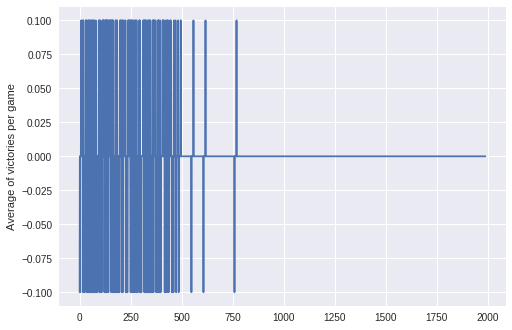

In [9]:
#matplotlib for rendering
import matplotlib.pyplot as plt
#Python image libarary for rendering
from PIL import Image
#iPython display for making sure we can render the frames
from IPython import display
from IPython.display import clear_output
#seaborn for rendering
import seaborn

#Setup matplotlib so that it runs nicely in iPython
%matplotlib inline
#setting up seaborn
seaborn.set()


def moving_average_diff(a, n=10):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(win_hist))
plt.ylabel('Average of victories per game')
plt.show()
plt.savefig("testES_2000epochs.png")